In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import random
import functools

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import ipywidgets as wg

import feature_utils
import stats_utils

In [2]:
def create_time_series_dict(df):
    time_series = {}

    for row in tqdm(df.to_dict("records")):
        time_series[row['id']] = {
            "time_series": pd.Series(data=row['values'], index=row['dates']),
            "label": row['label']
        }

    return time_series

In [3]:
def visualize_time_series(time_series_data, ts_id):

    if ts_id not in time_series_data:
        print(f"Error: ID {ts_id} not found in the time series data.")
        return

    time_series = time_series_data[ts_id]["time_series"]
    label = time_series_data[ts_id]["label"]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(time_series)
    ax1.set_title(f"Time Series for ID {ts_id} (class = {int(label)}, len = {int(len(time_series))})")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Value")

    N = len(time_series)
    T = 1.0  
    yf = np.fft.fft(time_series)
    xf = np.fft.fftfreq(N, T)[:N//2] 

    ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]))  
    ax2.set_title("Fourier Frequency Domain")
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Magnitude")

    plt.tight_layout()
    plt.show()


In [4]:
def apply_and_plot_distribution(time_series_data, function):

    transformed_series = []

    for data in tqdm(time_series_data.values()):
        transformed_series.append(function(data["time_series"]))

    plt.hist(transformed_series, bins=20, edgecolor='black')
    plt.xlabel("Transformed Value")
    plt.ylabel("Frequency")

    plt.show()

In [5]:
data_train = pd.read_parquet('source/train.parquet')
data_test = pd.read_parquet('source/test.parquet')
data_train

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


In [6]:
rus = RandomUnderSampler(random_state=42)   

X = data_train[['id', 'dates', 'values']]  
y = data_train['label']   

X_resampled, y_resampled = rus.fit_resample(X, y)
df_undersampled = pd.DataFrame(data=X_resampled, columns=['id', 'dates', 'values'])
df_undersampled['label'] = y_resampled

In [7]:
data_test['label'] = -1

In [8]:
time_series_data = create_time_series_dict(df_undersampled)
time_series_data_test = create_time_series_dict(data_test)

100%|██████████| 20000/20000 [00:00<00:00, 30959.69it/s]


In [9]:
time_series_data

{97797: {'time_series': 2016-01-01   -0.71
  2016-02-01   -0.08
  2016-03-01    0.42
  2016-04-01    0.03
  2016-05-01   -1.66
                ... 
  2023-01-01    2.57
  2023-02-01    0.09
  2023-03-01    1.46
  2023-04-01    1.92
  2023-05-01   -0.07
  Length: 89, dtype: float64,
  'label': 0.0},
 26218: {'time_series': 2019-07-01   -0.50
  2019-08-01    0.22
  2019-09-01   -0.69
  2019-10-01    1.12
  2019-11-01    0.62
  2019-12-01   -1.39
  2020-01-01   -1.20
  2020-02-01    0.28
  2020-03-01    0.32
  2020-04-01   -3.06
  2020-05-01    2.41
  2020-06-01    1.75
  2020-07-01    2.18
  2020-08-01    0.45
  2020-09-01    1.01
  2020-10-01    0.84
  2020-11-01   -0.08
  2020-12-01    2.45
  2021-01-01   -0.10
  2021-02-01    0.37
  2021-03-01   -1.95
  2021-04-01    1.32
  2021-05-01    0.82
  2021-06-01    0.60
  2021-07-01   -1.20
  2021-08-01   -0.33
  2021-09-01   -0.96
  2021-10-01   -0.39
  2021-11-01   -0.78
  2021-12-01   -2.11
  2022-01-01   -1.43
  2022-02-01   -1.68
  2022

In [9]:
N = 15
ts_ids_subsample = random.sample(list(time_series_data.keys()), N)

In [28]:
@wg.interact(ts_id = ts_ids_subsample)
def interactive_bench_choose(ts_id):
    visualize_time_series(time_series_data, ts_id)

interactive(children=(Dropdown(description='ts_id', options=(13273, 56166, 35557, 98377, 27257, 34886, 17917, …

: 

: 

100%|██████████| 44360/44360 [00:00<00:00, 1238438.77it/s]


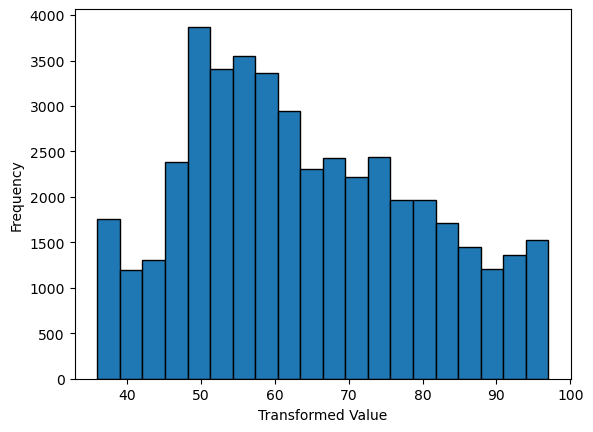

In [10]:
apply_and_plot_distribution(time_series_data, len)

100%|██████████| 44360/44360 [00:01<00:00, 27045.54it/s]


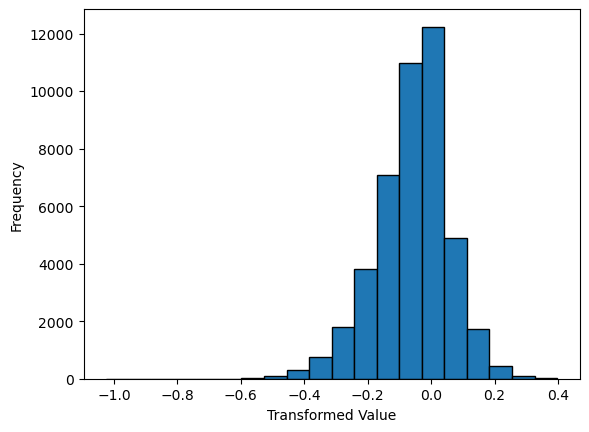

In [11]:
apply_and_plot_distribution(time_series_data, np.mean)

100%|██████████| 44360/44360 [00:00<00:00, 60656.90it/s]


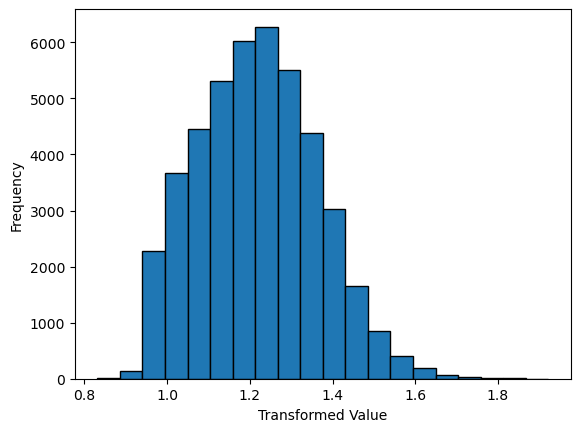

In [12]:
apply_and_plot_distribution(time_series_data, np.std)

100%|██████████| 44360/44360 [00:00<00:00, 59866.65it/s]


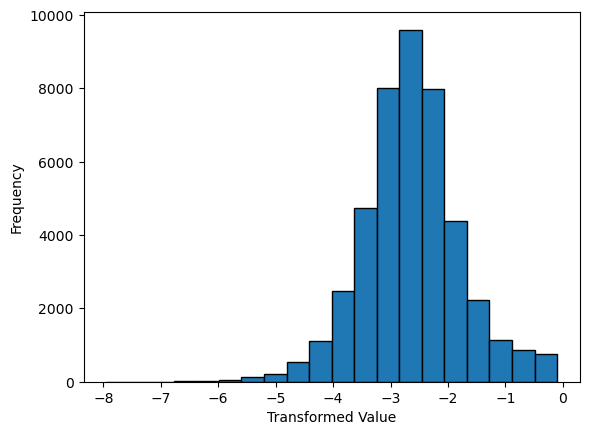

In [13]:
apply_and_plot_distribution(time_series_data, np.min)

100%|██████████| 44360/44360 [00:00<00:00, 59895.96it/s]


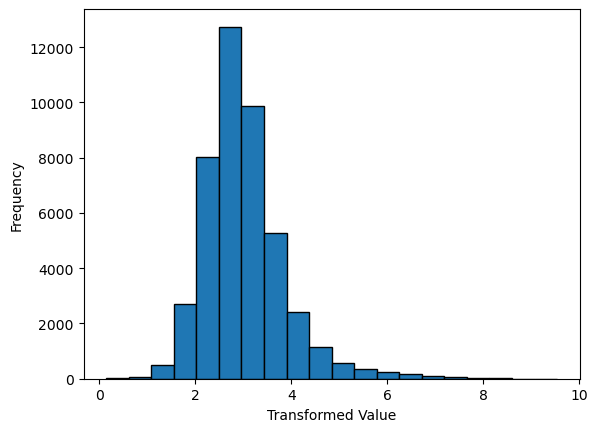

In [14]:
apply_and_plot_distribution(time_series_data, np.max)

In [15]:
stats_features = {
    'length': len,
    'mean': np.mean,
    'std': np.std,
    "min": np.min,
    "max": np.max,
    'max_diff': stats_utils.max_diff
}

In [16]:
business_features = {
    "absolute_gain_basis": stats_utils.absolute_gain_basis,
    "growth_coef_basis": stats_utils.growth_coef_basis,
    "average_gain_rate": stats_utils.average_gain_rate,
    "average_growth_rate": stats_utils.average_growth_rate,
    "average_absolute_gain": stats_utils.average_absolute_gain,
}

In [17]:
X_train, y_train = feature_utils.construct_features_df_parallel(time_series_data, [
    functools.partial(feature_utils.get_fn_features, stats_features),
    functools.partial(feature_utils.get_fourier_features, 15), 
    functools.partial(feature_utils.get_ma_features, [3, 5, 10, 15, 20, 30, 35]),
    functools.partial(feature_utils.get_fn_features, business_features),
    feature_utils.get_lr_features,
    functools.partial(feature_utils.get_outlier_features, 1.5)
])

100%|██████████| 44360/44360 [00:15<00:00, 2952.96it/s]


In [19]:
X_test, _ = feature_utils.construct_features_df_parallel(time_series_data_test, [
    functools.partial(feature_utils.get_fn_features, stats_features),
    functools.partial(feature_utils.get_fourier_features, 15), 
    functools.partial(feature_utils.get_ma_features, [3, 5, 10, 15, 20, 30, 35]),
    functools.partial(feature_utils.get_fn_features, business_features),
    feature_utils.get_lr_features,
    functools.partial(feature_utils.get_outlier_features, 1.5)
])

100%|██████████| 20000/20000 [00:07<00:00, 2532.31it/s]


In [22]:
X_train.head()

,length,mean,std,min,max,max_diff,F0,F1,F2,F3,...,MA35,absolute_gain_basis,growth_coef_basis,average_gain_rate,average_growth_rate,average_absolute_gain,beta0,beta1,tukey_low_outliers,tukey_high_outliers
0,89,0.095393,1.273631,-2.76,3.05,4.09,0.190787,0.565679,0.244923,0.138412,...,0.627143,0.64,-0.901408,0.000115,0.345659,1.030227,-0.548772,0.014315,0,0
1,37,-0.081081,1.259603,-3.06,2.45,5.47,0.162162,0.849959,0.340860,0.425167,...,-0.077714,0.01,-0.020000,-0.020286,-2.207293,1.237500,0.492162,-0.030171,0,0
2,57,0.124386,1.321100,-3.64,3.04,4.07,0.248772,0.138890,0.260475,0.395748,...,0.238571,-1.78,-0.585526,0.024000,-0.285100,1.066429,0.007807,0.004020,1,0
3,58,0.027586,0.987498,-1.37,3.98,5.35,0.055172,0.044818,0.137464,0.097714,...,-0.002286,-1.77,-1.806122,-0.014286,-1.815750,0.893509,0.139927,-0.003808,0,4
4,48,0.262083,1.297570,-2.64,3.31,3.75,0.524167,0.236284,0.228305,0.427451,...,0.332571,2.16,-15.428571,0.030000,2.796696,1.382128,-0.006853,0.010977,0,0


In [23]:
X_test.head()

,length,mean,std,min,max,max_diff,F0,F1,F2,F3,...,MA35,absolute_gain_basis,growth_coef_basis,average_gain_rate,average_growth_rate,average_absolute_gain,beta0,beta1,tukey_low_outliers,tukey_high_outliers
0,57,0.037895,1.505985,-3.14,3.13,3.27,0.075789,0.526357,0.368924,0.439431,...,0.155714,-2.120000,-1.145946,-0.004182,-0.431342,1.427500,0.328421,-0.010018,0,0
1,55,-0.016909,1.249663,-2.24,3.85,5.05,0.033818,0.511880,0.240649,0.231141,...,-0.011143,2.790000,-6.804878,0.037547,1.296236,1.382037,0.243616,-0.009304,0,2
2,55,-0.039569,1.000514,-1.45,3.46,2.67,0.079138,0.644831,0.296348,0.350860,...,0.184106,1.677809,-5.785548,0.049959,-0.696581,0.911892,-0.752063,0.025446,0,1
3,78,0.159231,1.313112,-2.73,3.43,4.26,0.318462,0.541414,0.395444,0.450931,...,-0.286571,0.790000,-0.537415,-0.029342,-0.939533,1.223506,0.495794,-0.008521,0,3
4,65,-0.094705,1.243279,-2.66,2.57,4.53,0.189411,0.311590,0.436018,0.926994,...,-0.402739,-3.827317,-1.642625,-0.045830,-1.437023,1.148552,0.721372,-0.024730,0,0


In [24]:
model_xgb = xgb.XGBClassifier()

In [25]:
param_dist = {
    'n_estimators': [50, 100, 150, 200, 300, 500, 1000],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3]
}

random_search = RandomizedSearchCV(estimator=model_xgb,
                                   param_distributions=param_dist,
                                   n_iter=100,  
                                   scoring='roc_auc',   
                                   n_jobs=-1, 
                                   cv=5,  
                                   verbose=10)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'n_estimators': [50, 100, 150, 200, 300,
                                                         500, 1000],
                                        'subsample': [0.5, 0.7, 0.9, 1.0]},
                   scoring='roc_auc', verbose=10)

In [26]:
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.4f}")

Best Parameters: {'subsample': 0.7, 'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best Cross-Validation Score: 0.9263


In [ ]:
best_model = random_search.best_estimator_
y_pred = best_model.predict_proba(X_test)

In [31]:
best_model.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0])

In [36]:
submission = data_test[['id']].assign(score = y_pred[:,1])
submission

,id,score
0,6125,0.176922
1,26781,0.369939
2,13333,0.709935
3,53218,0.055179
4,84204,0.806977
...,...,...
19995,80341,0.370572
19996,5891,0.074258
19997,29091,0.018509
19998,85877,0.250739


In [37]:
submission.to_csv('submission.csv', index=False)